In [1]:
import gpflow
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

data_dir = '/Users/mvanins/Documents/RPF/analysis/GPtest/RPF/RPF_replicate_20210414/'

%matplotlib inline

In [2]:
Y = pd.read_csv(data_dir + 'F3_RPF_seurat_integrated.csv', index_col=[0]).T
mData = pd.read_csv(data_dir + 'F3_RPF_seurat_integrated_meta.csv', index_col=[0])

mData = mData[mData['path'].notna()]
Y = Y.loc[list(mData.index.values),:]


N, D = Y.shape
print('Cells: %s, Genes: %s'%(N, D))

Cells: 3276, Genes: 1588


In [3]:
mData.head()

,CB,well,plate,cds,utr3,utr5,cds_frac,cell_total,sort_population,type,...,n_tours,path,log_green,log_red,seurat_clusters,percent_mt,UMAP_1,UMAP_2,population,population_order
G011_AACCACGTCA,G011_AACCACGTCA,M6,G011,17801,687,1260,0.901408,19748,G0,RPF,...,1468,2.520130,1.211853,3.069702,2,0.255300,6.843755,4.014378,G0,0
G011_AAGCACTGTC,G011_AAGCACTGTC,K24,G011,24519,1660,1929,0.872314,28108,Interphase,RPF,...,3728,4.467591,2.433899,2.936584,5,0.378254,-1.755797,-7.504097,Interphase,2
G011_AATGACGCGG,G011_AATGACGCGG,M17,G011,20630,1690,1134,0.879594,23454,Interphase,RPF,...,1136,2.423735,1.332703,3.004578,1,0.476443,4.623247,0.474879,Interphase,2
G011_ACAGATCTCA,G011_ACAGATCTCA,I5,G011,14587,984,786,0.891789,16357,G0,RPF,...,2635,3.290484,1.398315,3.450500,2,0.252629,6.550642,4.118356,G0,0
G011_ACCGGCCTTA,G011_ACCGGCCTTA,K9,G011,14960,1324,890,0.871084,17174,Interphase,RPF,...,1109,2.283665,0.973267,3.022034,2,0.339051,5.977729,1.085841,Interphase,2


In [4]:
max(mData['path'])

12.2503663906737

In [5]:
Y.head()

,ENSG00000286522.1-H3C2,ENSG00000038427.16-VCAN,ENSG00000187837.3-H1-2,ENSG00000287080.1-H3C3,ENSG00000168298.6-H1-4,ENSG00000278828.1-H3C10,ENSG00000131747.15-TOP2A,ENSG00000148677.6-ANKRD1,ENSG00000148773.14-MKI67,ENSG00000118523.6-CCN2,...,ENSG00000196821.10-ILRUN,ENSG00000121578.13-B4GALT4,ENSG00000187742.15-SECISBP2,ENSG00000005436.14-GCFC2,ENSG00000213995.11-NAXD,ENSG00000146535.14-GNA12,ENSG00000168575.10-SLC20A2,ENSG00000136560.14-TANK,log_red,log_green
G011_AACCACGTCA,-0.604980,2.015673,0.274866,0.206983,1.138600,0.524898,-1.052928,-0.961628,-0.972473,0.286107,...,-0.382962,-0.294597,-0.337047,-0.328594,-0.462827,2.241765,-0.540111,1.013073,0.680431,-0.434508
G011_AAGCACTGTC,2.227242,0.357818,2.053762,2.385233,1.705641,2.197032,0.692175,-0.441837,0.977959,0.529067,...,2.484561,1.506975,1.151870,-0.328594,-0.462827,-0.569503,-0.540111,-0.466177,0.543401,0.871682
G011_AATGACGCGG,-0.604980,1.314029,-0.703496,-0.531178,-1.233665,-0.548668,-1.052928,1.907440,-0.972473,1.930479,...,1.525116,-0.294597,1.392723,-0.328594,-0.462827,0.909720,-0.540111,-0.466177,0.613392,-0.305337
G011_ACAGATCTCA,-0.604980,1.190640,0.242786,-0.531178,0.345667,-0.548668,-1.052928,-0.961628,-0.972473,-0.903411,...,2.144602,2.477928,-0.337047,-0.328594,1.746339,2.672203,-0.540111,-0.466177,1.072419,-0.235206
G011_ACCGGCCTTA,-0.604980,1.187917,0.561248,-0.531178,0.651066,-0.548668,-0.682819,-0.512915,-0.972473,0.342167,...,-0.382962,-0.294597,-0.337047,-0.328594,-0.462827,1.349539,1.414164,-0.466177,0.631361,-0.689522


In [6]:
all(mData.index.values == Y.index.values)

True

In [7]:
Y = tf.convert_to_tensor(Y, dtype=default_float())

In [8]:
latent_dim = 1
num_inducing = 30 #30
num_data = Y.shape[0]

In [9]:
np.random.seed(112)
tf.random.set_seed(112)
#sigma_t = 0.8 #1.4, 1.2
sigma_t = 0.9 #1.4, 1.2

prior_mean = tf.convert_to_tensor( mData['path'].values[:, None], dtype=default_float())
X_prior_var = tf.convert_to_tensor(np.square(sigma_t) * np.ones((N,latent_dim)), dtype=default_float())

init_mean = mData['path'].values[:, None]
X_init_mean = tf.convert_to_tensor([init_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)], dtype=default_float()) # initialisation of latent_mean 
X_init_var = tf.convert_to_tensor(0.8*np.ones((N,latent_dim)), dtype=default_float())

In [10]:
prior_mean

<tf.Tensor: shape=(3276, 1), dtype=float64, numpy=
array([[2.52012982],
       [4.46759135],
       [2.42373534],
       ...,
       [2.80391712],
       [1.86732155],
       [2.91451622]])>

In [11]:
lengthscales = tf.convert_to_tensor(0.5, dtype=default_float())
kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(lengthscales=lengthscales), period=20.0)

In [12]:
gplvm = gpflow.models.BayesianGPLVM(
    Y,
    X_data_mean=X_init_mean,
    X_data_var=X_init_var,
    X_prior_mean=prior_mean,
    X_prior_var=X_prior_var,
    kernel=kernel,
    num_inducing_variables = num_inducing,    
)
gplvm.likelihood.variance.assign(1.1) #5.1
gplvm.default_jitter = 1E-6

In [13]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)
_ = opt.minimize(
  gplvm.training_loss,
  variables=gplvm.trainable_variables,
  options=dict(maxiter=maxiter),
)

In [14]:
print_summary(gplvm)

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,0.16882677843965688
BayesianGPLVM.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.021723252186043384
BayesianGPLVM.kernel.period,Parameter,Softplus,,True,(),float64,127.89904971606872
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.8299976329184078
BayesianGPLVM.X_data_mean,Parameter,Identity,,True,"(3276, 1)",float64,[[2.29488766...
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(3276, 1)",float64,[[0.00982486...
BayesianGPLVM.inducing_variable.Z,Parameter,Identity,,True,"(30, 1)",float64,[[-1.01927034e+01...


In [15]:
latent_mean = gplvm.X_data_mean.numpy()[:, 0:1]
sorted_latent_mean = np.sort(latent_mean, axis=0)
n_points = 1000
#Xnew = np.linspace(min(latent_mean), max(latent_mean), n_points)[:, None].reshape(n_points,1)
#Xnew = np.linspace(sorted_latent_mean.item(3), sorted_latent_mean.item(-3), n_points)[:, None].reshape(n_points,1)
Xnew = np.linspace(sorted_latent_mean.item(3), sorted_latent_mean.item(-6), n_points)[:, None].reshape(n_points,1)
Xnew = tf.convert_to_tensor(Xnew, dtype=default_float())

In [16]:
pm, pv = gplvm.predict_y(Xnew)
pseudotimes = gplvm.X_data_mean.numpy()[:, 0:latent_dim]
posterior_var = gplvm.X_data_var.numpy()[:, 0:latent_dim]
mean = pm.numpy()
var = pv.numpy()

In [17]:
#selectedGenes = ['ENSG00000286522.1-H3C2', "ENSG00000065328.16-MCM10", 'ENSG00000138778.13-CENPE',
#                 'ENSG00000131747.15-TOP2A', 'ENSG00000136997.19-MYC', 'ENSG00000145386.10-CCNA2']
selectedGenes = ['log_green', 'log_red', 'ENSG00000138778.13-CENPE',
                 'ENSG00000131747.15-TOP2A', 'ENSG00000286522.1-H3C2', 'ENSG00000145386.10-CCNA2']


#selectedGenes = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6']
Y = pd.read_csv(data_dir + 'F3_RPF_seurat_integrated.csv', index_col=[0]).T
mData = pd.read_csv(data_dir + 'F3_RPF_seurat_integrated_meta.csv', index_col=[0])

mData = mData[mData['path'].notna()]
Y = Y.loc[list(mData.index.values),:]



geneProfiles = pd.DataFrame({selectedGenes[i]: Y[selectedGenes[i]] for i in range(len(selectedGenes))})

In [18]:

geneNames = Y.columns.values
name = [_ for _ in geneNames]
posterior_mean = pd.DataFrame(mean, columns=name)
posterior_var = pd.DataFrame(var, columns=name)

#geneData = pd.read_csv('../data/McDavid/McDavid_gene.csv', index_col=0).T


In [19]:
def plot_genes(pseudotimes, geneProfiles, prediction):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'Gray'
    plt.rc('xtick', labelsize=15)

    selectedGenes = geneProfiles.keys().values

    # startTime = 1.
    # endTime = 3.55
    # timeDiff = 0.85
    # cbPeaktime = np.zeros(len(selectedGenes))
    # for g in range(0, len(selectedGenes)):
    #     cbPeaktime[g] = cbtime_to_tau(geneData[selectedGenes[g]].cbPeaktime, startTime, endTime, timeDiff)
    #     # print(geneData[selectedGenes[g]].cbPeaktime)

    Xnew = prediction[0]
    meanDf = prediction[1]
    varDf = prediction[2]
    # Create a Dataframe to contain predictive mean and variance
    predictDf = {}
    for i in range(len(selectedGenes)):
        predictDf[selectedGenes[i]] = pd.DataFrame({'mean': meanDf[selectedGenes[i]], 'var': varDf[selectedGenes[i]]})

    # Plot the result
    title = 'CellCycle'
    xLabel = 'Pseudotime'
    yLabel = 'Expression'

    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8))

    # plt.suptitle(title, fontsize=16)
    fig.text(0.5, -0.04, xLabel, ha='center', va='center', fontsize=20)
    fig.text(0.04, 0.5, yLabel, ha='center', va='center', rotation='vertical', fontsize=20)

    # xValues = np.array([1., 1.85, 2.7, 3.55])
    # xString = np.array(['G2/M', 'G0/G1', 'S', 'G2/M'])
    # plt.xticks(xValues, xString)
    # plt.xlim(1., 3.55)

    # # Following codes are used just to add legends
    # cellCycleStages = {'g0/g1': u'red', 's': u'green', 'g2/m': u'blue'}
    # stageColorCodes = ['red', 'green', 'blue']
    # color_map = [stageColorCodes[cpt[i] - 1] for i in range(len(cpt))]
    # markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', markersize=9, linestyle='') for color in
    #            cellCycleStages.values()]
    # l = plt.legend(markers, cellCycleStages.keys(), numpoints=1, title='Capture Stages', bbox_to_anchor=(1.6, 1.1),
    #                loc=10, fontsize=20, frameon=False)
    # plt.setp(l.get_title(), fontsize=20)

    n = 0
    for row in ax:
        for col in row:
            col.plot(Xnew[:, 0], predictDf[selectedGenes[n]]['mean'].values, 'black', lw=1)
            col.fill_between(Xnew[:, 0], predictDf[selectedGenes[n]]['mean'].values - \
                             2 * np.sqrt(predictDf[selectedGenes[n]]['var'].values),
                             predictDf[selectedGenes[n]]['mean'].values + \
                             2 * np.sqrt(predictDf[selectedGenes[n]]['var'].values), color='grey', alpha=0.5)
            # col.scatter(pseudotimes, geneProfiles[selectedGenes[n]], 130, marker='.', c=color_map, alpha=0.6)
            col.scatter(pseudotimes, geneProfiles[selectedGenes[n]], 130, marker='.', c='red', alpha=0.6)
            col.set_title(selectedGenes[n], fontsize=16)
            #col.axvline(cbPeaktime[n], linestyle='--', color='black')
            plt.setp(col.xaxis.get_majorticklabels(), rotation=90)
            col.yaxis.set_tick_params(labelsize=14)
            n = n + 1

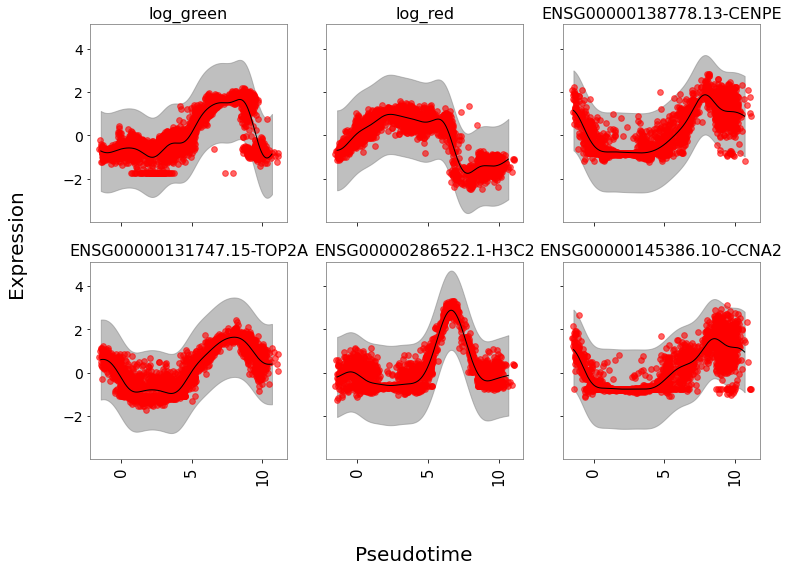

In [20]:

#from utils import plot_genes


plot_genes(pseudotimes, geneProfiles, prediction=(Xnew.numpy(), posterior_mean, posterior_var))

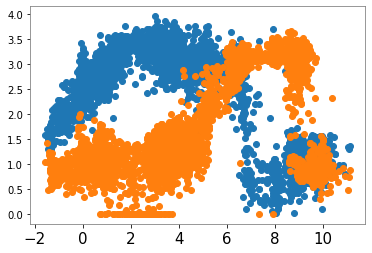

In [21]:
# plot fluorescence
#mData["log_green"]
plt.scatter(pseudotimes, mData['log_red'])
plt.scatter(pseudotimes, mData['log_green'])

In [22]:
posterior_mean.to_csv(data_dir + 'prediction/' + "prediction_withfacs_posterior_mean.csv.gz", mode = "w", compression = "infer")
posterior_var.to_csv(data_dir + 'prediction/' + "prediction_withfacs_posterior_var.csv.gz", mode = "w", compression = "infer")
np.savetxt(data_dir + 'prediction/' + "prediction_withfacs_xnew.csv.gz", Xnew.numpy(), delimiter=',')
np.savetxt(data_dir + 'prediction/' + "pseudotimes_withfacs.csv.gz", pseudotimes, delimiter=',')
pd.DataFrame(mData.index.values).to_csv(data_dir + 'prediction/' + "cellNames.csv.gz", mode="w", compression="infer")